# Essentials

As a Canvas Admin Wizard there are three key areas that your tasks are likely to fall into:


+ Enrollments
+ Assignments
+ Submissions

Before we begin, create your `canvas` session variable again by running the cell below with `API_URL` AND `API_KEY` set to your own personal values.

In [1]:
# Create your Canvas session

from canvasapi import Canvas

API_URL = "" # e.g. "https://liverpool.instructure.com"
API_KEY = ""

API_URL = "https://canvas.liverpool.ac.uk"
API_KEY = "15502~DqhNjK9tqamH68fsXvkoPkvH3Jgk5Tu5Uf5p4MFiCjoiUKGJBeqR7vgFs3yOj9Oe"

canvas = Canvas(API_URL, API_KEY)

## Enrollments

### Getting all enrollments on a course

In most cases when performing your Canvas wizardry, you'll need to start by getting a single course. Replace set the `course_id` variable in the cell below with the course id corresponding to a Canvas course that you are enrolled on as a teacher.

```{note}
If you don't know a course's id, you can get it by going to the course's homepage on Canvas and then looking at the last number in the URL string, e.g. for https://canvas.liverpool.ac.uk/courses/60371 the course id is 60371.
```

In [ ]:
course_id = 61073 # REPLACE 61073 WITH YOUR COURSE ID - I'm just giving an example here.
course = canvas.get_course(course_id)

To view all of the settings for the course use the `__dict__` method:

In [ ]:
course.__dict__

If you want, you can also get a course based on the course_code which is usually the course name as it appears in the top left of the course homepage on Canvas. You will need to use the additional parameter `use_sis_id` in the `get_course()` function, and make sure it's set to a value of `True`.

In [ ]:
# Getting a course with its course_code instead of the id
# LIFE733-202223 is used as an example here. User your own course_code!

course = canvas.get_course("LIFE733-202223", use_sis_id=True)

Use the `get_enrollments()` function to get all the enrollments associated with the course.

In [ ]:
# To get all the enrollments on a course
enrollments = course.get_enrollments()

The line above will successfully return all enrollments for a course and store them in the variable `enrollments`. However, all the information will stored in an object called a `PaginatedList` which isn't that useful when trying to do stuff in Python. For example, if you want to figure out how many enrollments there are you might try and use the `len()` function (very sensible), but for a `PaginatedList` you'd encounter a `TypeError`.

In [ ]:
len(enrollments)

To avoid `TypeErrors`, it is recommended that you retrieve list of things from canvas by using the relevant function, in this case `course.get_enrollments()`, within what is known as a "list comprehension" in Python. Without going into any futher detail, the code you need is as follows ...

In [ ]:
enrollments = [x for x in course.get_enrollments()]

```{note}
This slightly more complicated way of obtaining a list of things from Canvas is better in the long run. You'll see it used a lot when I'm getting enrollments, assignments and submissions.
```

In [ ]:
len(enrollments) # That's better! I can see there are 68 enrollments on this course.

Also, you can now slice your list of enrollments, e.g. to pick out a single enrollment from the list to look at it, by doing something like this ...

In [ ]:
# Example: Pick out the 65th enrollment from a list of enrollments.
enrollments[65]

To make the data associated with the enrollment a bit more readable you can use the `__dict__` method.

In [ ]:
# Use .__dict__ to print out the dictionary map for the enrollment object. Beatuful!
enrollments[65].__dict__

You can access any "key value" associated with the enrollment object by using `.<key_name>` on any enrollment object. For example, to get the role associated the object above:

In [ ]:
# Get the role associated with my enrollment
enrollments[65].role

Sometimes, you just want to get the enrollments associated with a particular role, e.g. ``StudentEnrolment``. To do this you can filter accordingly using the following line.

In [ ]:
student_enrollments = [x for x in course.get_enrollments() if x.role == "StudentEnrollment"]

### Export course enrollments

Sometimes, it's really useful to get export all of the enrollments on a Canvas course to an Excel spreadsheet. This might be required, for example, if you wanted to manually allocate students to particular groups in Canvas and wanted to prepare a batch spreadsheet with a "Group Name" column.

How do we do this? We do it with [Pandas](https://pandas.pydata.org/)!

Run the cell below to create a Pandas data frame containing your enrollment data.

In [ ]:
# The pandas module is fantastic for reading/creating spreadsheets from data in Python
import pandas as pd

rows = [] #create an empty list to store your row data

# Loop over all your student enrollments
for e in student_enrollments:
    # Create a dictionary containing useful info from each enrollment
    row = {
        "user_id": e.user_id,
        "sortable_name": e.user["sortable_name"],
        "role": e.role,
        "course_section_id": e.course_section_id
    }
    rows.append(row) # add the dictionary to the rows list.

output = pd.DataFrame(rows) # Convert your rows into a Pandas dataframe

You can view the first 5 rows of your data frame using the following command.

In [ ]:
# check it out!
output.head()

Finally, lets save the data frame to something we all know and love - the humble Excel spreadsheet.

In [ ]:
# Save the output to an Excel spreadsheet
output.to_excel("course_enrollments.xlsx", index=False)

```{note}
If you're running a Binder instance of this chapter then click File --> Open, tick the checkbox next to the "course_enrollments.xlsx" file and then hit the Download button to get a copy of your saved spreadsheet.

Similarly, if you're using Collab, click the files icon in the left toolbar, find your file and click the elipsis next to the filename to download the file.
```

### Enrolling Users

Enrolling users onto a Canvas course using the LMS interface is somewhat clunky. You have to type in the `login_id` (usually an email) of each user manually one-by-one and click a few more buttons. If you need to add many users (sometimes hundreds) to a new course it might be easier to use some more wizadry.

```{note}
When enrolling users to a Canvas course using the LMS an unavoidable invite notification will be sent via email to the user. You can, however, prevent this behaviour using the API.
```

Below is an example of how to enroll a new user (in this case me! - my id is a very Orwellian 101) as a Teacher on a course. The `enrollment` dictionary contains information on the `enrollment_state` of the user. By setting it to `active` we can avoid sending the user any notification of their enrollment which is sometimes preferable.

In [ ]:
# Enrollment example

course.enroll_user(user=101, #the id of the user
                   enrollment_type="TeacherEnrollment", # use "StudentEnrollment" if you want to enrols as student.
                   enrollment={
                       "enrollment_state": "active" # important! Otherwise use will receive notification.
                   }
                  )

And hey presto! The user is enrolled. If you navigate to the "People" section of the course via the LMS you should now be able to see the enrollment.

Very often it is necessary to take all the enrollments from one course and replicated them on another. Remember that `course_enrollments.xlsx` spreadsheet that you created above. Let's use this to enrol all of the students on another course.

In [ ]:
# Read the spreadsheet to a data frame variable called `user_sheet`
user_sheet = pd.read_excel("course_enrollments.xlsx")

In [ ]:
user_sheet.columns

In [ ]:
# enroll them on another course
# I'll use my own personal test course for this example, id=53523
# https://canvas.liverpool.ac.uk/courses/53523/users
# You can use any other course you're enrolled on.

test_course = canvas.get_course(53523)

for i, row in user_sheet.iterrows():
    print("Enrolling user: ", row.user_id) # Print out a line-by-line log of what's going on.
    
    # Enroll each user in turn from the data frame
    
    try:
        test_course.enroll_user(user=row.user_id, 
                       enrollment_type=row.role,
                       enrollment={
                           "enrollment_state": "active" # important! Otherwise use will receive notification.
                       }
                      )
    except:
        print("Couldn't enroll user: {} ({})".format(row.sortable_name, row.user_id))

Checkout the "People" area on your test course now. You should see that all the students in the spreadsheet have been enrolled.

### Deleting Users

Unless you're super important, and have Canvas superuser permissions granted by some boffin your IT department, you won't be able to remove users from a course using the LMS. This is often a source of serious consternation for teachers who need to remove students from their courses and also for students who have de-registered from a course but still keep receiving Canvas notifications. 

Luckily for you, users *can* be removed using the Canvas API.

As an example, let's get all the student enrollments on a course, print them out in a big list and then delete the enrollment chose enrollment.

In [ ]:
# Get all student enrollments on the test_course we used above
# Note: I'm filtering the enrollments so I don't include my own enrollment on the course (I can't delete mysef!)

enrollments = [x for x in test_course.get_enrollments() if x.type=="StudentEnrollment" and "Treharne" not in x.user["name"]]

In [ ]:
# Loop over all your enrollments and print out the index and user name
for i, e in enumerate(enrollments):
    print(i, e.id, e.user["sortable_name"])

Select the enrollmet you want to delete by using `[x]` at the end of your `enrollments` variable, where `x` is the index of the enrollment (you printed them out above).

In [ ]:
# Select the enrollment to delete
# Arbitrarily I'm going to delete the first enrollment (i.e. use [0] to slice)

enrollment_to_delete = enrollments[15]

Now, use the `.deactivate` function. Make sure you pass it a `task` variable with the value `"delete"` set.

In [ ]:
# Select the enrollment you want to delete by using `[x]` at the end of your `enrollment

enrollment_to_delete.deactivate(task="delete")

If you run the cells above that to get and print your enrollments again, you should see that the first enrollment is now gone! If you want to go a step further here and delete *all* your student enrollments from the course then you can run the following cell.

```{warning}
There's no way of undoing the following. It is strongly recommended that you export the course enrollments to a spreadsheet (see above) and keep the file in a safe place just in case you need to re-add the students to the course.
```

In [ ]:
# Remove ALL students from a course
# Only do this if you're absolutely sure!

for e in enrollments:
    try:
        e.deactivate(task="delete")
        print("{} ({}) removed from course.".format(e.user["sortable_name"], e.user["id"]))
    except:
        print("No enrollment to delete!")

## Assignments

TODO:

+ Getting Assignments
+ Editing Existing Assignments
+ Creating New assignments
+ Duplicating assignments

In [ ]:
### Getting Assignments



In [ ]:
from canvasapi import Canvas

canvas = Canvas("https://canvas.liverpool.ac.uk", "15502~DqhNjK9tqamH68fsXvkoPkvH3Jgk5Tu5Uf5p4MFiCjoiUKGJBeqR7vgFs3yOj9Oe")

In [ ]:
# first get the course
course = canvas.get_course(53523) # 53523 is the id of my personal test course

# then get the assignment
assignment = course.get_assignment(224200) # 224200 is the assignment id. Get it from the assignment url. 

In [ ]:
# inspect the assignment object
assignment.__dict__

In [ ]:
# get all course assignments
assignments = [x for x in course.get_assignments()]

In [ ]:
for a in assignments:
    print(a)

In [ ]:
# filter assignments based on key value
assignments = [x for x in course.get_assignments() if x.due_at == "2023-01-09T12:00:00Z"]

In [ ]:
assignments = [x for x in course.get_assignments() if "test" in x.name.lower()]

### Edit Assignments

In [ ]:
a = assignments[0] # from above

assignment_update_info = {
    "description": "Important information about this assignment",
    "due_at": "2023-01-09T16:00:00Z", # important to get the format correct
    "name": "Awesome Assignment",
    "published": False
}

a = a.edit(assignment=assignment_update_info)

### Duplicate Assignments

In [ ]:
import requests

def duplicate_assignment(course_id, assignment_id):
    """
    This function takes an assignment and makes an identical duplicate.
    You will make sure your API_URL and API_KEY variables are set
    before using this function. Also, import the requests module.
    """
    
    # set the url endpoint
    url = f'{API_URL}/api/v1/courses/{course_id}/assignments/{assignment_id}/duplicate'
    
    # set the request header for authentication
    header = {'Authorization': 'Bearer {}'.format(API_KEY)}
    
    # make the request
    r = requests.post(url, headers=header)
    
    # get the new assignment
    assignment = canvas.get_course(course_id).get_assignment(r.json()["id"])
    
    return assignment

In [ ]:
# Running this cell will copy your assignment from above. Check this in Canvas
new_assignment = duplicate_assignment(course.id, a.id)

In [ ]:
new_assignment.name

In [ ]:
new_assignment = new_assignment.edit(
    assignment={
        "name": "Another Awesome Assignment",
        "published": True,
        "due_at": "2023-01-10T12:00:00Z"
    }
)

In [ ]:
for i in range(1,6):
    new_assignment = duplicate_assignment(course.id, a.id)
    new_assignment.edit(
        assignment={
            "name": "Assignment {}".format(str(i)),
            "published": True,
            "position": i+1 # This will make sure they appear in the correct order
        }
    )

### Importing Assignments

In [ ]:
def import_assignment(from_course_id, to_course_id, assignment_id):
    settings = {
        "source_course_id": from_course_id,
        "selective_import": True,
      }

    select = {
        "assignments": [assignment_id]
    }

    canvas.get_course(to_course_id).create_content_migration(migration_type="course_copy_importer", settings=settings, select=select)

In [ ]:
# https://canvas.liverpool.ac.uk/courses/58338/assignments/201149
import_assignment(58338, course.id, 201149)

You can import anything!

https://canvas.instructure.com/doc/api/content_migrations.html#method.content_migrations.create

## Submissions

In [155]:
course = canvas.get_course("LIFE113-202122", use_sis_id=True)

In [156]:
assignments = [x for x in course.get_assignments()]

In [157]:
for a in assignments:
    print(a)

Student Survey (194236)
Fizzy Newt | Record Session Attendance (149927)
Fizzy Newt | Record An Absence (149928)
Moles, Concentrations and Dilutions Practice Problems (154730)
Unit Conversion (154729)
Good Laboratory Practice (GLP) V1.2 (190769)
LIFE113.1 (40%) - Test 1 (Summative) (165716)
LIFE113.0 (60%) - Test 2 (Summative) (168483)
RESIT LIFE113.1 (40%) - Test 1 (199616)
RESIT LIFE113.0 (60%) - Test 2 (199617)


In [158]:
assignments = [x for x in course.get_assignments() if "LIFE113." in x.name]

In [159]:
assignment = assignments[1]

In [178]:
submissions = [x for x in assignment.get_submissions(include=["user"])]
#submissions = [x for x in assignment.get_submissions(include=["user"])]

In [174]:
len(submissions)

428

In [177]:
submissions[0].__dict__

{'_requester': <canvasapi.requester.Requester at 0x7efd3d253070>,
 'id': 15946621,
 'body': 'user: 3283, quiz: 116522, score: 60.0, time: 2022-01-20 11:44:59 +0000',
 'url': None,
 'grade': '60',
 'score': 60.0,
 'submitted_at': '2022-01-20T11:44:59Z',
 'submitted_at_date': datetime.datetime(2022, 1, 20, 11, 44, 59, tzinfo=<UTC>),
 'assignment_id': 168483,
 'user_id': 3283,
 'user_id_date': datetime.datetime(3283, 1, 1, 0, 0, tzinfo=<UTC>),
 'submission_type': 'online_quiz',
 'workflow_state': 'graded',
 'grade_matches_current_submission': True,
 'graded_at': '2022-01-20T11:44:59Z',
 'graded_at_date': datetime.datetime(2022, 1, 20, 11, 44, 59, tzinfo=<UTC>),
 'grader_id': -116522,
 'attempt': 1,
 'cached_due_date': '2022-01-21T16:00:00Z',
 'cached_due_date_date': datetime.datetime(2022, 1, 21, 16, 0, tzinfo=<UTC>),
 'excused': None,
 'late_policy_status': None,
 'points_deducted': None,
 'grading_period_id': None,
 'extra_attempts': None,
 'posted_at': '2022-02-10T11:10:55Z',
 'posted_

In [172]:
import pandas as pd
from datetime import datetime, date
import pytz

rows = []
for sub in submissions:
    if "submitted_at_date" in sub.__dict__.keys():
        if sub.submitted_at_date <= assignment.due_at_date: # 
            rows.append(
                {
                    "course_code": course.course_code,
                    "assignment": assignment.name,
                    "anonymous_id": sub.anonymous_id,
                    "score": sub.score,
                    "submitted_at": sub.submitted_at_date.replace(tzinfo=None),
                    "date": sub.submitted_at_date.date(),
                    "url": "https://canvas.liverpool.ac.uk/courses/{0}/gradebook/speed_grader?assignment_id={1}&anonymous_id={2}".format(course.id, assignment.id, sub.anonymous_id)
                }
            )

data = pd.DataFrame(rows)    

#data = data[data["date"] < max(data["date"].tolist())]

In [181]:
data.head()

,course_code,assignment,anonymous_id,score,submitted_at,date,url
0,LIFE113-202122,LIFE113.0 (60%) - Test 2 (Summative),h3pgr,60.0,2022-01-20 11:44:59,2022-01-20,https://canvas.liverpool.ac.uk/courses/46832/g...
1,LIFE113-202122,LIFE113.0 (60%) - Test 2 (Summative),6e6xp,20.0,2022-01-21 13:43:52,2022-01-21,https://canvas.liverpool.ac.uk/courses/46832/g...
2,LIFE113-202122,LIFE113.0 (60%) - Test 2 (Summative),gRxLo,30.0,2022-01-21 12:41:04,2022-01-21,https://canvas.liverpool.ac.uk/courses/46832/g...
3,LIFE113-202122,LIFE113.0 (60%) - Test 2 (Summative),HCKTn,80.0,2022-01-17 15:42:28,2022-01-17,https://canvas.liverpool.ac.uk/courses/46832/g...
4,LIFE113-202122,LIFE113.0 (60%) - Test 2 (Summative),JcvcC,60.0,2022-01-17 18:26:04,2022-01-17,https://canvas.liverpool.ac.uk/courses/46832/g...


In [170]:
data.to_excel("LIFE113_2022122_online_test_results.xlsx")

In [ ]:
summary = data["score"].describe()

In [182]:
summary

count    374.000000
mean      70.407754
std       19.321193
min       30.000000
25%       55.000000
50%       70.000000
75%       85.000000
max      100.000000
Name: score, dtype: float64

(0.0, 90.0)

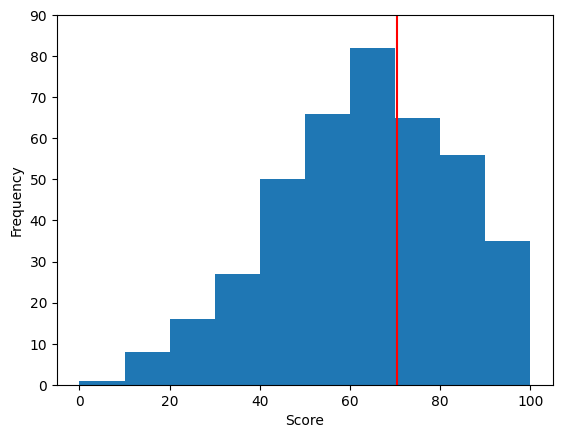

In [185]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.hist(data["score"])
ax.vlines(summary["mean"], ymin=0, ymax=90, color='red')
ax.set_xlabel("Score")
ax.set_ylabel("Frequency")
ax.set_ylim(0, 90)

Text(0.5, 0.98, '')

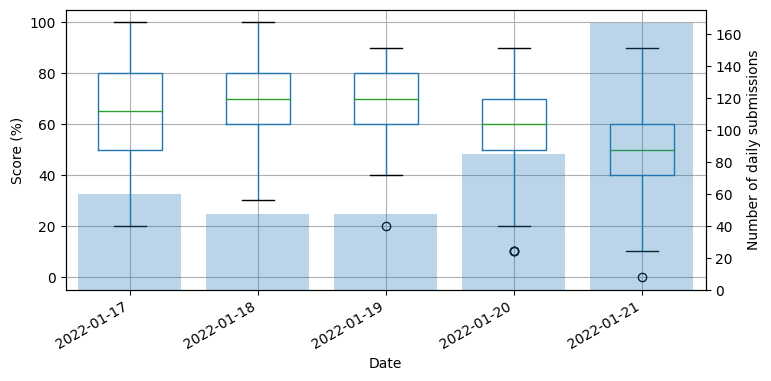

In [186]:
fig, ax = plt.subplots(figsize=(8, 4))
ax2 = ax.twinx()
df_gb = data.groupby('date').count()
data.boxplot(column='score', by='date', ax=ax)
ax2.bar(range(1, len(df_gb['score'])+1), height=df_gb['score'],align='center', alpha=0.3)
fig.autofmt_xdate()
ax.set_xlabel("Date")
ax.set_ylabel("Score (%)")
ax2.set_ylabel("Number of daily submissions")
ax.set_title("")
fig.suptitle("")